In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
print(os.listdir('/content/drive/My Drive/'))

['Colab Notebooks', 'Resume Folder', 'Certifications', 'CBSE', 'College Semester Certificates', 'ISTE Membership Paid Proof.jpg', 'Community_Connect_Certificate.pdf', 'Hackathon and Coding Certificate', 'Internship', 'TESS Toronto emotional speech set data', 'Nlp hall ticket .pdf', 'LLM _nptel_hallticket.pdf', 'Communication networks NPTEL hall ticket .pdf']


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import Audio
import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
data_dir = '/content/drive/My Drive/TESS Toronto emotional speech set data'
print(os.listdir(data_dir))




['YAF_angry', 'OAF_neutral', 'OAF_Sad', 'YAF_disgust', 'OAF_angry', 'OAF_happy', 'OAF_Pleasant_surprise', 'OAF_Fear', 'TESS Toronto emotional speech set data', 'OAF_disgust', 'YAF_happy', 'YAF_pleasant_surprised', 'YAF_neutral', 'YAF_sad', 'YAF_fear']


In [6]:
# Initialize empty lists for features and labels
features = []
labels = []
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        emotion_label = folder.split('_')[-1]  # Extract the emotion label from the folder name

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_path.endswith('.wav'):
                # Load the audio file and extract features
                audio, sr = librosa.load(file_path, duration=3)  # Adjust the duration as needed
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(emotion_label)

In [7]:
features = np.array(features)
labels = np.array(labels)


In [8]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [9]:
# Define the emotions and the number of samples to select from each emotion
emotions = ['angry', 'disgust', 'Fear', 'happy', 'neutral', 'Sad']
num_samples_per_emotion = 3
# Initialize empty lists for storing the selected samples
selected_samples = []

In [10]:


# Iterate through the emotions and select samples
for emotion in emotions:
    emotion_dir = os.path.join(data_dir, f'OAF_{emotion}')
    audio_files = os.listdir(emotion_dir)
    selected_files = np.random.choice(audio_files, size=num_samples_per_emotion, replace=False)

    for file_name in selected_files:
        file_path = os.path.join(emotion_dir, file_name)
        audio, sr = librosa.load(file_path, duration=3)
        selected_samples.append((audio, sr, emotion))


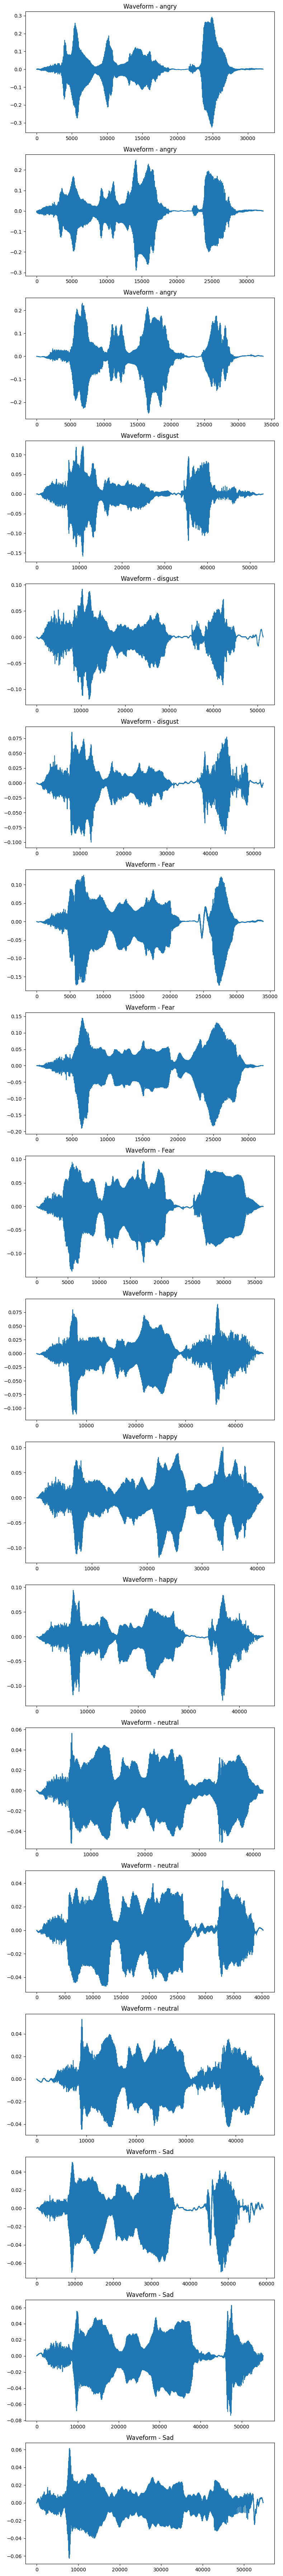

In [11]:
# Plot the selected samples
num_samples = len(selected_samples)
plt.figure(figsize=(8, 4 * num_samples))

for i, (audio, sr, emotion) in enumerate(selected_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(audio)
    plt.title(f'Waveform - {emotion}')

plt.tight_layout()
plt.show()

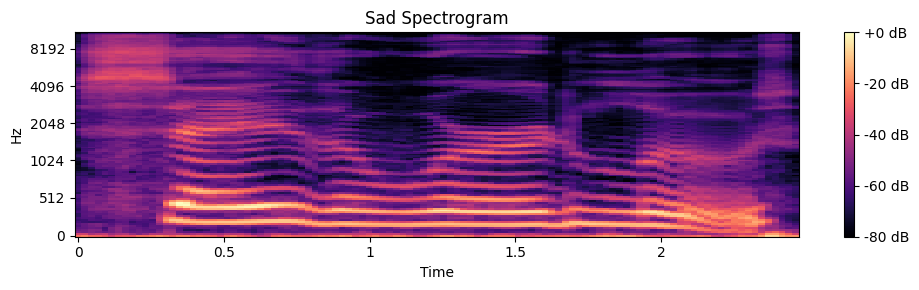

In [12]:

# Calculate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

# Convert power spectrogram to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 3))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Sad Spectrogram')
plt.tight_layout()
plt.show()
Audio(file_path)



In [13]:


import numpy as np
import librosa

# Define the pitch shifting function
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Apply audio transformations (e.g., noise addition, time stretching, pitch shifting)
augmented_features = []
augmented_labels = []

# Define a fixed length (assuming all original features have the same length)
fixed_length = max(len(f) for f in features)  # Find the longest sample length

for feature, label in zip(features, labels):
    # Store the original feature
    augmented_features.append(librosa.util.fix_length(feature, size=fixed_length))
    augmented_labels.append(label)

    # Apply noise addition
    noise = np.random.randn(len(feature))
    noisy_feature = feature + 0.005 * noise  # Adjust the noise magnitude as needed
    augmented_features.append(librosa.util.fix_length(noisy_feature, size=fixed_length))
    augmented_labels.append(label)

    # Apply time stretching (adjusted for length mismatch)
    time_stretched = librosa.effects.time_stretch(feature, rate=1.2)
    time_stretched = librosa.util.fix_length(time_stretched, size=fixed_length)
    augmented_features.append(time_stretched)
    augmented_labels.append(label)

    # Apply pitch shifting
    pitch_shifted = pitch(feature, sampling_rate=22050, pitch_factor=0.7)
    pitch_shifted = librosa.util.fix_length(pitch_shifted, size=fixed_length)
    augmented_features.append(pitch_shifted)
    augmented_labels.append(label)

# Convert lists to NumPy arrays
augmented_features = np.array(augmented_features, dtype=object)  # Use dtype=object if still getting shape issues
augmented_labels = np.array(augmented_labels)

# Print the number of original and augmented samples
print('Original samples:', len(features))
print('Augmented samples:', len(augmented_features))



/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=13
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=13
  warnings.warn(


Original samples: 2800
Augmented samples: 11200


In [14]:
# Define a list to store the preprocessed data
preprocessed_data = []
file_list = os.listdir(data_dir)
# Iterate over the files
for filename in file_list:
    file_path = os.path.join(data_dir, filename)

    # Skip non-audio files
    if not filename.endswith('.wav'):
        continue

    # Load the audio file and obtain the waveform and sample rate
    waveform, sr = librosa.load(file_path, sr=None, dtype=np.float32)

    # Resample the audio if needed
    if sr != 22050:
        waveform = librosa.resample(waveform, sr, 22050)
        sr = 22050

In [15]:
label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
encoded_labels = np.array([label_mapping.get(label, -1) for label in labels])

# Filter out any samples with unknown emotion labels
valid_indices = np.where(encoded_labels != 1)[0]  # Get the indices from the tuple
features = features[valid_indices]
encoded_labels = encoded_labels[valid_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))


# Convert the emotion labels to categorical format
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [16]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1920, 13, 1)
y_train shape: (1920, 6)
X_test shape: (480, 13, 1)
y_test shape: (480, 6)


In [17]:
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(13, 1, 1), padding='same'))

# Flatten the output
model.add(Flatten())

# Add a dense layer0
model.add(Dense(32, activation='relu'))

# Add the output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 1, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        13,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,862 (54.15 KB)

 Trainable params: 13,862 (54.15 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3491 - loss: 11.1847 - val_accuracy: 0.3000 - val_loss: 2.1256
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4418 - loss: 1.5038 - val_accuracy: 0.6646 - val_loss: 0.8029
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6841 - loss: 0.7398 - val_accuracy: 0.7479 - val_loss: 0.6089
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7931 - loss: 0.5489 - val_accuracy: 0.7937 - val_loss: 0.5091
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8337 - loss: 0.4558 - val_accuracy: 0.8479 - val_loss: 0.4411
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8673 - loss: 0.3839 - val_accuracy: 0.8479 - val_loss: 0.3970
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8610 - loss: 0.3838 - val_accuracy: 0.8750 - val_loss: 0.3582
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8672 - loss: 0.3584 - val_accuracy: 0.8958 - val_los

In [19]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8890 - loss: 0.3101 
Accuracy of our model on test data :  88.7499988079071 %


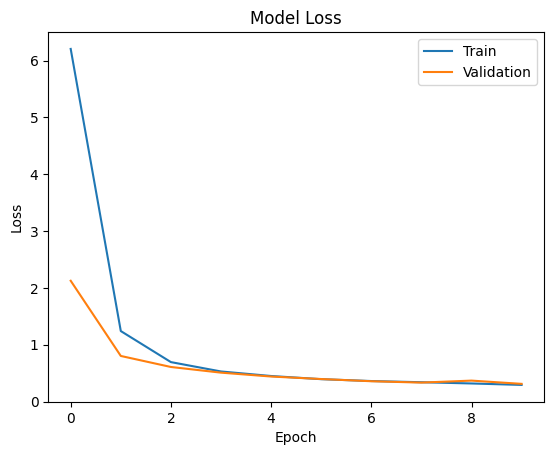

In [20]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

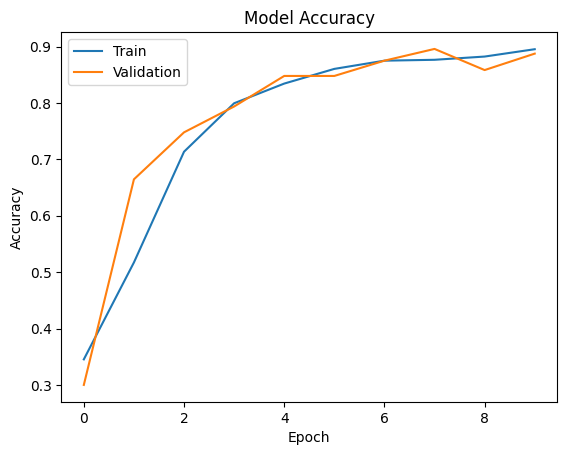

In [21]:


# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

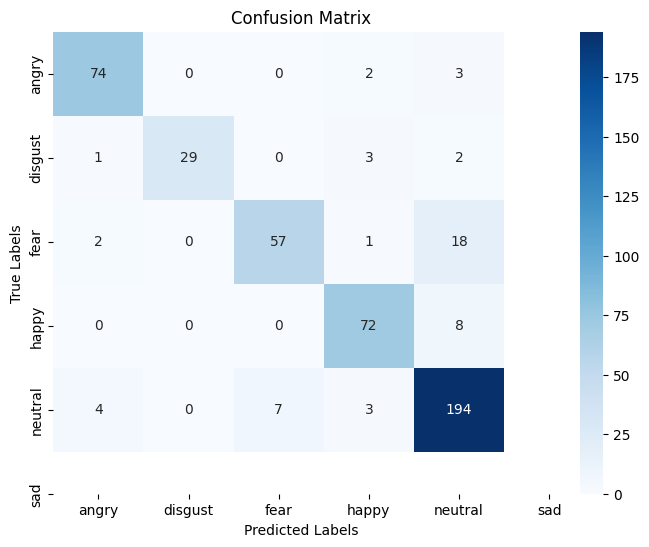

In [22]:
# Get the predicted labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert the true labels from one-hot encoding to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']  # Replace with your actual class names
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, labels=range(len(class_names)))

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [23]:
print(report)

              precision    recall  f1-score   support

       angry       0.91      0.94      0.93        79
     disgust       0.00      0.00      0.00         0
        fear       1.00      0.83      0.91        35
       happy       0.89      0.73      0.80        78
     neutral       0.89      0.90      0.89        80
         sad       0.86      0.93      0.90       208

    accuracy                           0.89       480
   macro avg       0.76      0.72      0.74       480
weighted avg       0.89      0.89      0.89       480



In [24]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=64)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8975 - loss: 0.2873 - val_accuracy: 0.8976 - val_loss: 0.2641
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9112 - loss: 0.2564 - val_accuracy: 0.8993 - val_loss: 0.2583
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8977 - loss: 0.2598 - val_accuracy: 0.8906 - val_loss: 0.2509
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9067 - loss: 0.2627 - val_accuracy: 0.8924 - val_loss: 0.2751
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9170 - loss: 0.2263 - val_accuracy: 0.8906 - val_loss: 0.2508
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9110 - loss: 0.2394 - val_accuracy: 0.9028 - val_loss: 0.2311
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9205 - loss: 0.2170 - val_accuracy: 0.9132 - val_loss: 0.2350
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9258 - loss: 0.2158 - val_accuracy: 0.9132 - val

In [25]:
print("Accuracy of our model on train data : " , model.evaluate(X_train,y_train)[1]*100 , "%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9246 - loss: 0.2069
Accuracy of our model on train data :  91.7187511920929 %
